In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [149]:
#raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)

### empirical data

#basic_df = pd.read_csv('../fairpair/data/imdb-wiki_results/IMDB-WIKI_basicMethods_evaluated.csv')
#GNN_df = pd.read_csv('../fairpair/data/imdb-wiki_results/IMDB-WIKI_GNNRank_reTrained_syncRank_evaluated.csv')
#full_df = pd.read_csv('../fairpair/data/imdb-wiki_results/IMDB-WIKI_basicMethods_fullDataset_evaluated.csv')
#full_GNN_df = pd.read_csv('../fairpair/data/imdb-wiki_results/IMDB-WIKI_GNNRank_fullDataset_evaluated.csv')
#full_df['iteration'] = 500
#full_GNN_df['iteration'] = 500
#raw_df = pd.concat([basic_df, GNN_df, full_df, full_GNN_df])
#raw_df['bias_applied'] = True

### chatbot arena data
full_df = pd.read_csv('../fairpair/data/chatbot_arena_results/chatbotArena_basicMethods_fullDataset_evaluated.csv')
full_GNN_df = pd.read_csv('../fairpair/data/chatbot_arena_results/chatbotArena_GNNRank_fullDataset_evaluated.csv')
full_df['iteration'] = 500
full_GNN_df['iteration'] = 500
raw_df = pd.concat([full_df, full_GNN_df])
raw_df['bias_applied'] = True


raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})


#### replace fairPageRank results with multigraph version

#raw_df = raw_df[raw_df['Ranking Method'] != 'fairPageRank']
#fairPR_multi_df = pd.read_csv('../fairpair/data/general_accuracy/generalAccuracy_fairPR_multigraph.csv')
#fairPR_multi_df['Ranking Method'] = 'Fairness-Aware PageRank'
#raw_df = pd.concat([raw_df, fairPR_multi_df])
#raw_df = raw_df[raw_df.bias_applied]


#### replace post-processed results

#fairPR_df = raw_df[raw_df['Ranking Method'] == 'Fairness-Aware PageRank'].copy()
#fairPR_df = fairPR_df.replace({'Fairness-Aware PageRank': 'Fairness-Aware PageRank\n(not post-processed)'})

#raw_df = pd.read_csv('../fairpair/data/post_processing/EPIRA_10trials.csv')
#raw_df = pd.read_csv('../fairpair/data/post_processing/EPIRA99_10trials.csv')
#raw_df = pd.read_csv('../fairpair/data/post_processing/FAstarIR_10trials.csv')
#raw_df = pd.read_csv('../fairpair/data/post_processing/FAstarIRp60_10trials.csv')
#raw_df = pd.read_csv('../fairpair/data/post_processing/IMDB-WIKI_EPIRA99_10trials_v2.csv')

#raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})
#raw_df = pd.concat([raw_df, fairPR_df])

raw_df

,trial,iteration,value,sampling method,Ranking Method,group attribute,benchmark,metric,group,bias_applied
0,0,500,0.306887,full dataset,rankCentrality,often_compared,helm,tau,Overall,True
1,0,500,0.331325,full dataset,rankCentrality,often_compared,helm,tau,Privileged,True
2,0,500,0.269068,full dataset,rankCentrality,often_compared,helm,tau,Unprivileged,True
3,0,500,0.423177,full dataset,rankCentrality,often_compared,helm,exposure,Privileged,True
4,0,500,0.340073,full dataset,rankCentrality,often_compared,helm,exposure,Unprivileged,True
...,...,...,...,...,...,...,...,...,...,...
91,0,500,0.381682,full dataset,GNNRank,open_source,arena_hard,exposure,Privileged,True
92,0,500,0.326762,full dataset,GNNRank,open_source,arena_hard,exposure,Unprivileged,True
93,0,500,0.419454,full dataset,GNNRank,open_source,arena_hard,tau,Privileged within-group,True
94,0,500,0.330099,full dataset,GNNRank,open_source,arena_hard,tau,Between groups,True


## 2D Plots

In [ ]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

In [ ]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

In [ ]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

In [ ]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

In [33]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality',
                                 'full dataset': 'Full Dataset'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

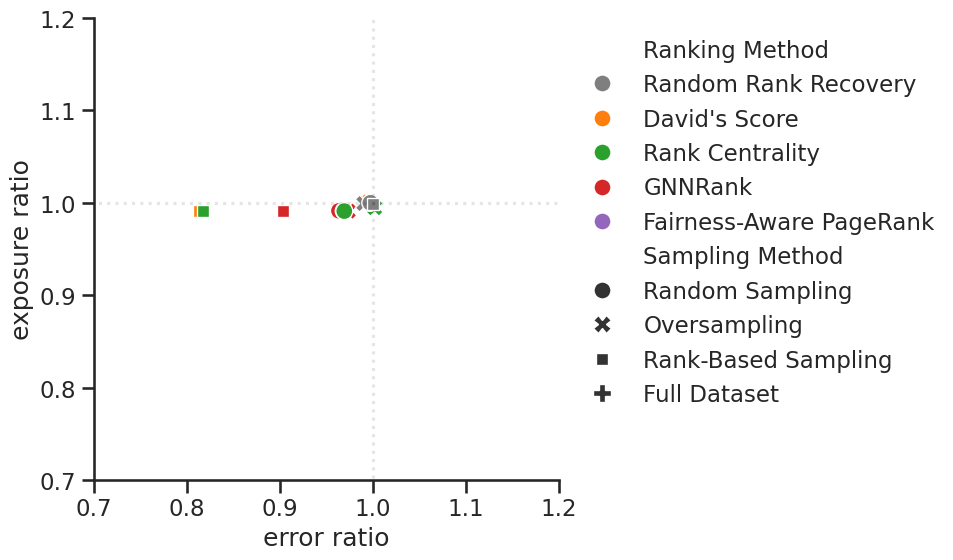

In [34]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling', 'Full Dataset']
df = df[df['Ranking Method'].isin(ranking_methods)]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=ranking_methods,
                         style_order=sampling_methods)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()

## Seperate 1D Plots

In [150]:
sel_df2 = raw_df[(raw_df.iteration == 500) & (raw_df.bias_applied == True)].drop(columns=['iteration', 'bias_applied'])
sel_df2 = sel_df2.pivot(index=['trial', 'sampling method', 'Ranking Method',
                               'group attribute', 'benchmark'], columns=['metric', 'group'], values='value').reset_index()
sel_df2.head()

metric trial sampling method Ranking Method group attribute   benchmark  \
group                                                                     
0          0    full dataset        GNNRank  often_compared      alpaca   
1          0    full dataset        GNNRank  often_compared  arena_hard   
2          0    full dataset        GNNRank  often_compared        helm   
3          0    full dataset        GNNRank     often_first      alpaca   
4          0    full dataset        GNNRank     often_first  arena_hard   

metric       tau                           exposure               \
group    Overall Privileged Unprivileged Privileged Unprivileged   
0       0.762471   0.732279     0.729845   0.392575     0.370675   
1       0.438759   0.452985     0.436896   0.318991     0.394168   
2       0.342251   0.355807     0.350293   0.331836     0.431414   
3       0.828759   0.812369     0.846288   0.308896     0.454354   
4       0.373690   0.390490     0.352464   0.365731     0.352102   

metric                     tau                                           
group  Privileged within-group Between groups Unprivileged within-group  
0                     0.852135       0.667177                  0.859035  
1                     0.450779       0.453581                  0.414400  
2                     0.322914       0.374262                  0.280359  
3                     0.754169       0.833013                  0.872327  
4                     0.506084       0.358038                  0.345102

In [151]:
sel_df3 = sel_df2.copy()
sel_df3['exposure ratio'] = sel_df3['exposure']['Unprivileged'] / sel_df3['exposure']['Privileged']
sel_df3['error ratio'] = sel_df3['tau']['Unprivileged'] / sel_df3['tau']['Privileged']
sel_df3['exposure difference'] = sel_df3['exposure']['Unprivileged'] - sel_df3['exposure']['Privileged']
sel_df3['error difference'] = sel_df3['tau']['Unprivileged'] - sel_df3['tau']['Privileged']
sel_df3['error'] = sel_df3['tau']['Overall']
sel_df3 = sel_df3[['trial', 'sampling method', 'Ranking Method', 'exposure ratio', 'error ratio', 'error',
                   'error difference', 'exposure difference', 'group attribute', 'benchmark']].droplevel('group', axis=1)
sel_df3 = sel_df3.replace({'OversampleMinority': 'Oversampling',
                            'oversampling': 'Oversampling',
                            'RankSampling': 'Rank-Based Sampling',
                            'rankSampling': 'Rank-Based Sampling',
                            'RandomSampling': 'Random Sampling',
                            'randomSampling': 'Random Sampling',
                            'fairPageRank': 'Fairness-Aware PageRank',
                            'davidScore': "David's Score",
                            'randomRankRecovery': 'Random Rank Recovery',
                            'rankCentrality': 'Rank Centrality',
                            'btl': 'Bradley-Terry-Luce',
                            'full dataset': 'Full Dataset'})
sel_df3 = sel_df3.replace({'often_compared': 'model often\ncompared',
                           'often_first': 'model often\nshown first',
                           'often_formatted': 'output is\nformatted',
                           'open_source': 'model is\nclosed source',
                           })

sel_df3 = sel_df3.rename(columns={'sampling method': 'Sampling Method'})
sel_df3.head()

metric,trial,Sampling Method,Ranking Method,exposure ratio,error ratio,error,error difference,exposure difference,group attribute,benchmark
0,0,Full Dataset,GNNRank,0.944216,0.996677,0.762471,-0.002434,-0.021900,model often\ncompared,alpaca
1,0,Full Dataset,GNNRank,1.235671,0.964482,0.438759,-0.016089,0.075177,model often\ncompared,arena_hard
2,0,Full Dataset,GNNRank,1.300081,0.984503,0.342251,-0.005514,0.099578,model often\ncompared,helm
3,0,Full Dataset,GNNRank,1.470896,1.041753,0.828759,0.033919,0.145458,model often\nshown first,alpaca
4,0,Full Dataset,GNNRank,0.962736,0.902618,0.373690,-0.038027,-0.013629,model often\nshown first,arena_hard


In [152]:
# Okabe-Ito color palette
lightblue = "#56B4E9"
yellow = "#F0E442"
orange = "#E69F00"
green = "#009E73"
purple = "#CC79A7"
red = "#D55E00"
blue = "#0072B2"
black = "#000000"
#palette = [black, orange, lightblue, green, yellow, blue, red, purple] # original order
#palette = [black, orange, lightblue, green, red, purple] # custom order
palette = [black, orange, lightblue, green, red, blue] # custom order

#palette = sns.color_palette('tab10')
#palette[0] = palette[7]

sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = sel_df3
df = sel_df3[sel_df3.benchmark == 'arena_hard']
#ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank\n(not post-processed)']
#ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank', 'Bradley-Terry-Luce']

#df = df.replace({
#    'Random Rank Recovery': 'Random Rank Recovery\n& FA*IR',
#    'David\'s Score': 'David\'s Score\n& FA*IR',
#    'Rank Centrality': 'Rank Centrality\n& FA*IR',
#    'GNNRank': 'GNNRank\n& FA*IR'
#})
#ranking_methods = ['Random Rank Recovery\n& FA*IR', "David's Score\n& FA*IR", 'Rank Centrality\n& FA*IR', 'GNNRank\n& FA*IR', 'Fairness-Aware PageRank\n(not post-processed)']

sampling_methods = ['Full Dataset', 'Random Sampling', 'Oversampling', 'Rank-Based Sampling']
metrics = ['exposure difference', 'error difference', 'error']
group_attributes = ['model often\ncompared', 'model often\nshown first', 'model is\nclosed source', 'output is\nformatted']

df = df[df['Ranking Method'].isin(ranking_methods)]
df = df.melt(id_vars=['group attribute', 'Ranking Method'], value_vars=['error', 'exposure difference', 'error difference'])

df['metric_order'] = df.metric.map(metrics.index)
#df['sampling_order'] = df['Sampling Method'].map(sampling_methods.index)
df['attribute_order'] = df['group attribute'].map(group_attributes.index)
df['ranking_order'] = df['Ranking Method'].map(list(reversed(ranking_methods)).index)
df = df.sort_values(by=['ranking_order', 'attribute_order', 'metric_order']).drop(columns=['ranking_order', 'attribute_order', 'metric_order'])
df.head()

,group attribute,Ranking Method,metric,value
100,model often\ncompared,Bradley-Terry-Luce,exposure difference,0.031587
120,model often\ncompared,Bradley-Terry-Luce,exposure difference,0.016025
128,model often\ncompared,Bradley-Terry-Luce,exposure difference,-0.057138
136,model often\ncompared,Bradley-Terry-Luce,exposure difference,0.006586
144,model often\ncompared,Bradley-Terry-Luce,exposure difference,0.033270


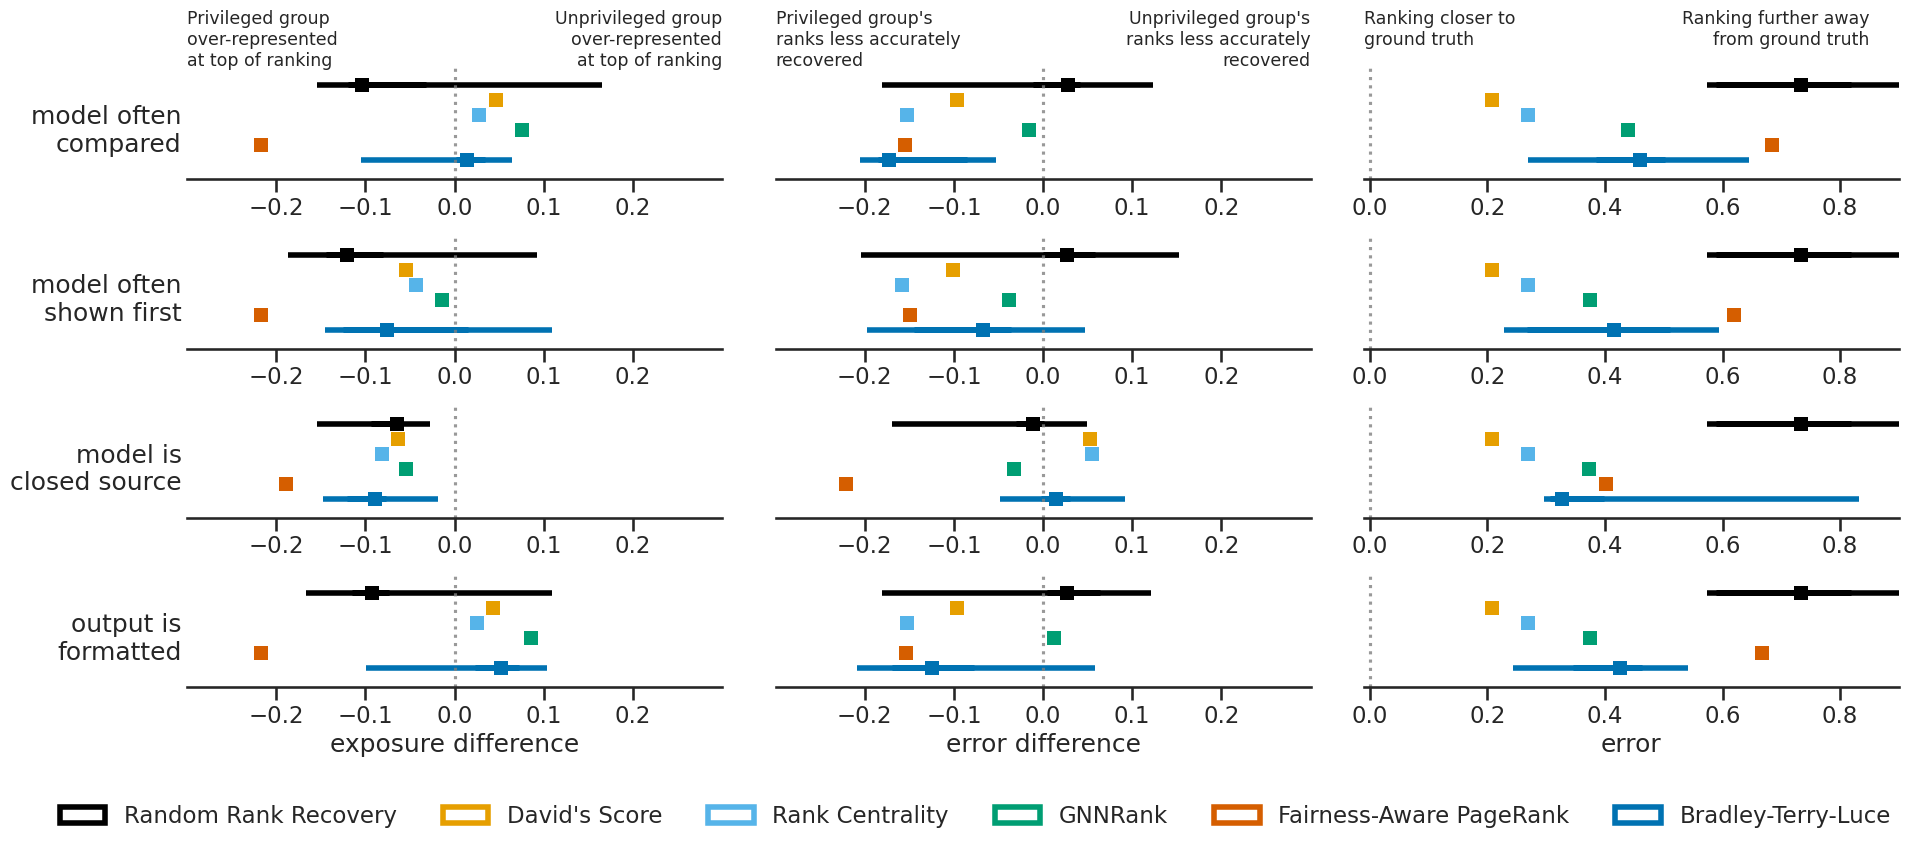

In [153]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.catplot(df, x='value', kind='box', #style='Sampling Method',
                    row='group attribute', col='metric', hue='Ranking Method',
                    hue_order=ranking_methods, sharex=False, sharey=True,
                    aspect=3/1, height=2,
                    # sns.boxplot properties
                    fill=False, whis=(0, 100), linewidth=4,
                    # plt.boxplot properties & Line2D properties
                    medianprops={'marker': '|', 'markeredgewidth': 10, 'markersize': 10}, showcaps=False,
                    #showmeans=True, meanprops={'marker': '|', 'markeredgecolor': 'black', 'markeredgewidth': 2, 'markersize': 10},
                    widths=0
                    )
    #g = sns.relplot(df, x='value', y='benchmark', kind='scatter', #style='Sampling Method',
    #                row='group attribute', col='metric', hue='Ranking Method', style='benchmark',
    #                hue_order=ranking_methods, #sharex=False, sharey=True,
    #                aspect=3/1, height=2,
    #                facet_kws={'sharey': True, 'sharex': False}
    #                )
    # s=40, alpha=0.8, facet_kws={'sharey': True, 'sharex': False}, height=1.8

#sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.008, 0))
sns.move_legend(g, 'upper left', ncol=6, title=None, bbox_to_anchor=(-0.05, 0))

g.refline(x=0, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((0.5,-0.5))
    #ax.set_ylim((-1,4))
    
    if col_val == 'error':
        #ax.set(xlim=(0.05,0.85))
        #ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
        #ax.set(xlim=(-0.01,0.85))
        #ax.set_xticks([0,.1,.2,.3,.4,.5,.6,.7,.8])
        ax.set(xlim=(-0.01,0.9))
        ax.set_xticks([0,.2,.4,.6,.8])
        #ax.set_xscale('log', base=10)
        pass
    else:
        #log_lim = 0.86
        #log_lim = 0.65
        #ax.set(xlim=(log_lim,1/log_lim))
        #ax.set_xscale('log', base=10)
        #ticks = [.9,.95,1,1.05,1.1,1.15]
        #ticks = [0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
        #ticklabels = [0.7,0.8,0.9,1,'',1.2,'',1.4]
        #ax.set_xticks(ticks)
        #ax.set_xticklabels(ticklabels)
        
        #ax.set(xlim=(-0.025,0.025))
        #ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
        #ax.set(xlim=(-0.13,0.13))
        #ax.set_xticks([-0.1,-0.05,0,0.05,0.1])
        ax.set(xlim=(-0.3,0.3))
        ax.set_xticks([-0.2,-0.1,0,0.1,0.2])
        pass

    if row_val == group_attributes[-1]: #'Rank-Based Sampling'
        ax.set_xlabel(col_val)
    else:
        #ax.set_xticklabels([])
        pass
    
    if col_val == 'exposure difference':
        #ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)
        ax.set_ylabel(row_val, rotation=0, horizontalalignment='right', y=0.2)
    
    if row_val == group_attributes[0]: #'Full Dataset', 'Random Sampling'
        y = -.5
        y_offset = -.5
        lim = -0.3 #-0.025 #-0.13 
        inv_lim = 0.3 #0.025 #0.13
        if col_val == 'exposure difference':
            ax.annotate('Privileged group\nover-represented\nat top of ranking',
                        xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\nover-represented\nat top of ranking',
                        xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error difference':
            ax.annotate('Privileged group\'s\nranks less accurately\nrecovered',
                        xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\'s\nranks less accurately\nrecovered',
                        xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error':
            ax.annotate('Ranking closer to\nground truth',
                        xy=(0.05, y), xytext=(-0.01,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Ranking further away\nfrom ground truth',
                        xy=(.85, y), xytext=(0.85,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')

sns.despine(left=True)
#plt.savefig('../fairpair/data/combined_plots/combined_results_diff_fairPR_multigraph.png', dpi=300, bbox_inches="tight")
#plt.savefig('../fairpair/data/combined_plots/FAstarIRp60_results_fairPR_multigraph.png', dpi=300, bbox_inches="tight")
#plt.savefig('../fairpair/data/combined_plots/chatbotArena_fullDataset_helmBenchmark.pdf', bbox_inches="tight")

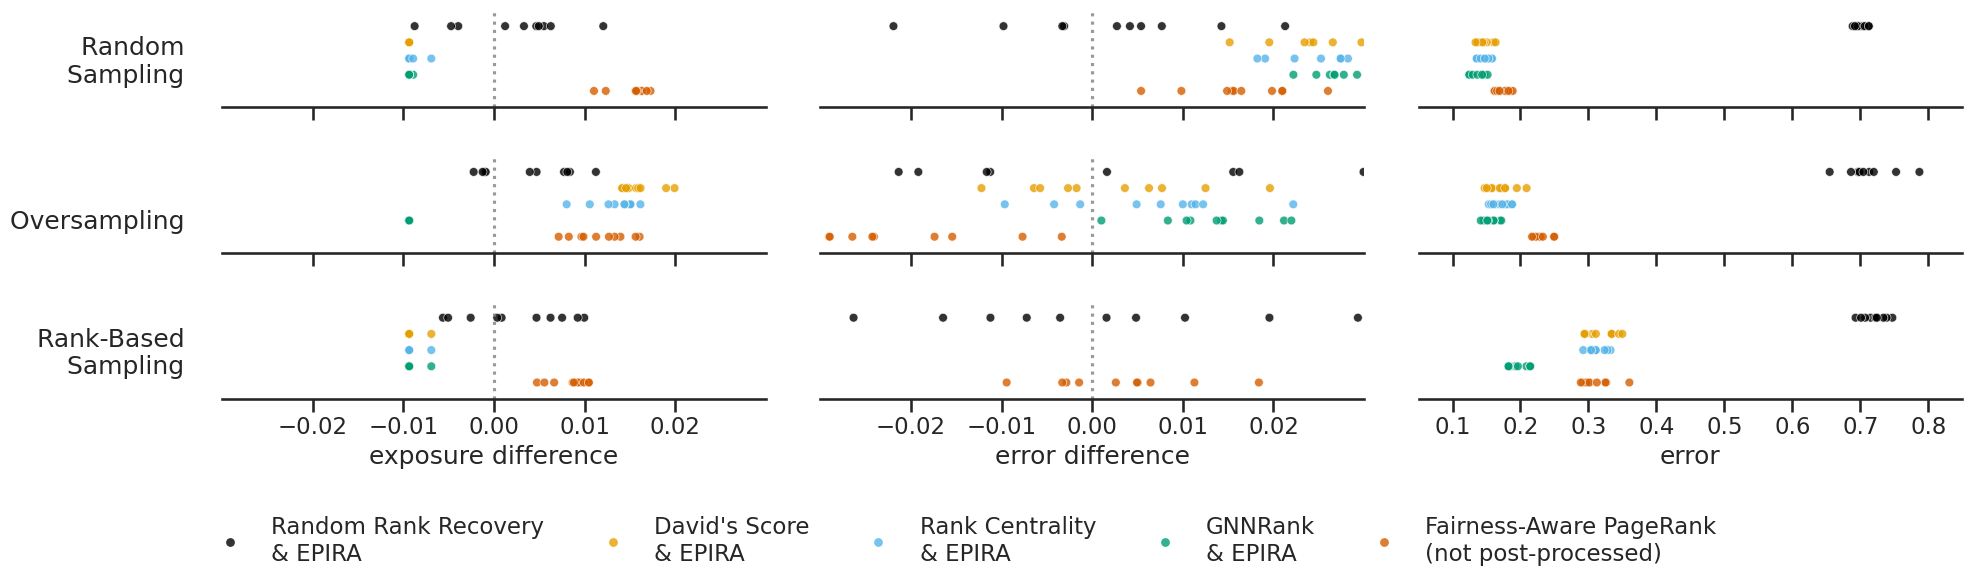

In [47]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.relplot(df, x='value', y='Ranking Method', hue='Ranking Method', kind='scatter', #style='Sampling Method',
                    row='Sampling Method', col='metric',
                    hue_order=ranking_methods, style_order=sampling_methods,
                    s=40, alpha=0.8, aspect=4/1, height=1.8, facet_kws={'sharey': True, 'sharex': False})

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=0, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(-0.03,0.03))
        ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
    
    if col_val == 'exposure difference':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
#plt.savefig('./data/others_results/combined_results_1D.png', dpi=300, bbox_inches="tight")